# <div align="center"><b> ПРОЕКТ №8. ВЫБОР ЛОКАЦИИ ДЛЯ СКВАЖИНЫ </b></div> 

**Цель:** целью проекта является выбор места для бурения новых скважин компанией "ГлавРосГосНефть". В рамках выполнения проекта требуется решить следующие **задачи**: 
- на основании исторических данных о запасах нефти в трех регионах обучить модель, по ключевым характеристикам предсказывающую потенциальные запасы сырья в скважине;
- определить минимально достаточный объем сырья, окупающий разработку скважин;
- рассчитать прибыль для двухсот наилучших скважин;
- определить среднюю прибыль, 95%-й доверительный интервал для средней прибыли, а также риск убытков (отрицательной прибыли).

# 1. Предобработка данных

С целью получения корректных результатов на этапе предобработки должно быть выполнено следующее:
- получение общей информации о данных, выявление возможных проблем;
- поиск и устранение аномальных значений (при необходимости);
- поиск и устранение пропусков (при необходимости);
- поиск и устранение явных и неявных дубликатов;
- корректировка типов данных (при необходимости).

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
#снимем ограничение на количество столбцов датафрейма, выводимых на экран
pd.options.display.max_columns = None

## 1.1 Обзор данных

Так как в рамках обзора данных для каждого датасета предусмотрены одни и те же опрации, напишем функцию, которая принимает на вход относительный путь к датасету, возвращает сам датасет, а также печатает следующую информацию о данных:
- первые пять строк датасета;
- общую информацию;
- статистическую информацию о числовых данных;
- статистическую информацию о текстовых данных.

In [3]:
#напишем функцию, импортирующую указанный датасет и отображающую основную информацию о данных
def data_info(relative_path):  #в формате '\имя_файла.csv'
    
    #импортируем данные в датафрейм
    try:
    # local machine
        path=r'C:\Users\vizum\Desktop\yandex_practicum\project_8\datasets'+relative_path
        df = pd.read_csv(path)
    except:
        #yandex practicum server
        df = pd.read_csv('/datasets'+relative_path)
            
            
    #выведем на экран первые пять строк датафрейма
    display('ПЕРВЫЕ ПЯТЬ СТРОК')
    display(df.head())
              
    #получим общую информацию о датафрейме
    display('ОБЩАЯ ИНФОРМАЦИЯ')
    display(df.info())
              
    #получим статистическую информацию о числовых данных
    display('СТАТИСТИКА О ЧИСЛОВЫХ ДАННЫХ')
    display(df.describe())
              
    #получим статистическую информацию о текстовых данных
    display('СТАТИСТИКА О ТЕКСТОВЫХ ДАННЫХ')
    display(df.describe(include = 'object'))  
              
    return df

### 1.1.1 Обзор данных по региону 0

In [4]:
geo_0 = data_info('/geo_data_0.csv')

'ПЕРВЫЕ ПЯТЬ СТРОК'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'ОБЩАЯ ИНФОРМАЦИЯ'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'СТАТИСТИКА О ЧИСЛОВЫХ ДАННЫХ'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'СТАТИСТИКА О ТЕКСТОВЫХ ДАННЫХ'

,id
count,100000
unique,99990
top,HZww2
freq,2


***Выводы по датасету geo_0:***
- пропуски отсутствуют;
- типы данных соответствуют данным;
- в столбце `product` аномальные данные отсутствуют (нет скважин с отрицательной величиной добычи);
- в столбце с уникальным идентификатором скважины - `id` - присутствует 10 дубликатов (0.01% от объема датасета);

Для дальнейшей работы с датасетом geo_0 требуется:
- провести проверку на полные дубликаты и выполнить их обработку (при необходимости), в том числе выполнить обработку дубликатов в столбце `id`;
- выполнить анализ данных на наличие выбросов. Анализ столбцов `id`, `f0`, `f1`, `f2` на аномальные значения невозможно, так как значение id может быть любым, а физическое значение параметров f0-f2 из условий задания не известно;
- после обработки дубликатов и поиска выбросов столбец c `id` необходимо удалить, так как для обучения он не нужен.

### 1.1.2 Обзор данных по региону 1

In [307]:
geo_1 = data_info('/geo_data_1.csv')

'ПЕРВЫЕ ПЯТЬ СТРОК'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'ОБЩАЯ ИНФОРМАЦИЯ'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'СТАТИСТИКА О ЧИСЛОВЫХ ДАННЫХ'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'СТАТИСТИКА О ТЕКСТОВЫХ ДАННЫХ'

,id
count,100000
unique,99996
top,bfPNe
freq,2


***Выводы по датасету geo_1:***
- пропуски отсутствуют;
- типы данных соответствуют данным;
- в столбце `product` аномальные данные отсутствуют (нет скважин с отрицательной величиной добычи);
- в столбце с уникальным идентификатором скважины - `id` - присутствует 4 дубликата (0.004% от объема датасета);

Для дальнейшей работы с датасетом geo_1 требуется:
- провести проверку на полные дубликаты и выполнить их обработку (при необходимости), в том числе выполнить обработку дубликатов в столбце `id`;
- выполнить анализ данных на наличие выбросов. Анализ столбцов `id`, `f0`, `f1`, `f2` на аномальные значения невозможно в силу вышеобозначенных причин;
- после обработки дубликатов и поиска выбросов столбец c `id` необходимо удалить, так как для обучения он не нужен.

### 1.1.3 Обзор данных по региону 2

In [308]:
geo_2 = data_info('/geo_data_2.csv')

'ПЕРВЫЕ ПЯТЬ СТРОК'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


'ОБЩАЯ ИНФОРМАЦИЯ'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'СТАТИСТИКА О ЧИСЛОВЫХ ДАННЫХ'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'СТАТИСТИКА О ТЕКСТОВЫХ ДАННЫХ'

,id
count,100000
unique,99996
top,xCHr8
freq,2


***Выводы по датасету geo_2:***
- пропуски отсутствуют;
- типы данных соответствуют данным;
- в столбце `product` аномальные данные отсутствуют (нет скважин с отрицательной величиной добычи);
- в столбце с уникальным идентификатором скважины - `id` - присутствует 4 дубликата (0.004% от объема датасета);

Для дальнейшей работы с датасетом geo_2 требуется:
- провести проверку на полные дубликаты и выполнить их обработку (при необходимости), в том числе выполнить обработку дубликатов в столбце `id`;
- выполнить анализ данных на наличие выбросов. Анализ столбцов `id`, `f0`, `f1`, `f2` на аномальные значения невозможно;
- после обработки дубликатов и поиска выбросов столбец c `id` необходимо удалить, так как для обучения он не нужен.

## 1.2 Поиск дубликатов

Проверим все датафреймы на наличие полных дубликатов. Строки с id-дубликатами удалим, так как они занимают менее 1% каждого датафрейма.

In [309]:
#проверим датафреймы на наличие полных дубликатов
for df in [geo_0, geo_1, geo_2]:
    print(df.duplicated().sum())

0
0
0


Полные дубликаты отсутствуют. Удалим строки с id-дубликатами.

In [310]:
for df in ['geo_0', 'geo_1', 'geo_2']:
    #удалим дубликаты
    locals()[df]=locals()[df].drop_duplicates(subset='id')
    
    #отобразим статистическую информацию 
    display(locals()[df].describe(include='object'))
    
    #добавим разделитель
    display(30*'*')

,id
count,99990
unique,99990
top,nBT1R
freq,1


'******************************'

,id
count,99996
unique,99996
top,DanHR
freq,1


'******************************'

,id
count,99996
unique,99996
top,63UOE
freq,1


'******************************'

Удалим из датасетов столбец с идентификаторами скважин.

In [311]:
for df in ['geo_0', 'geo_1', 'geo_2']:
    
    #удалим столбец с id
    locals()[df] = locals()[df].drop(columns='id').reset_index(drop=True)
    
    #выведем новые названия столбцов
    display(locals()[df].columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [312]:
#дополнительно проверим результаты предыдущих операций
for df in [geo_0, geo_1, geo_2]:
    df.info()
    #добавим разделитель
    display(30*'*')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


'******************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


'******************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


'******************************'

Удаление дубликатов и удаление столбца выполнено корректно.

## 1.3 Проверка данных на выбросы

Для анализа наличия выбросов для каждого датафрейма построим диаграммы размаха и точечные графики по каждому параметру. Воспользуемся циклом. 

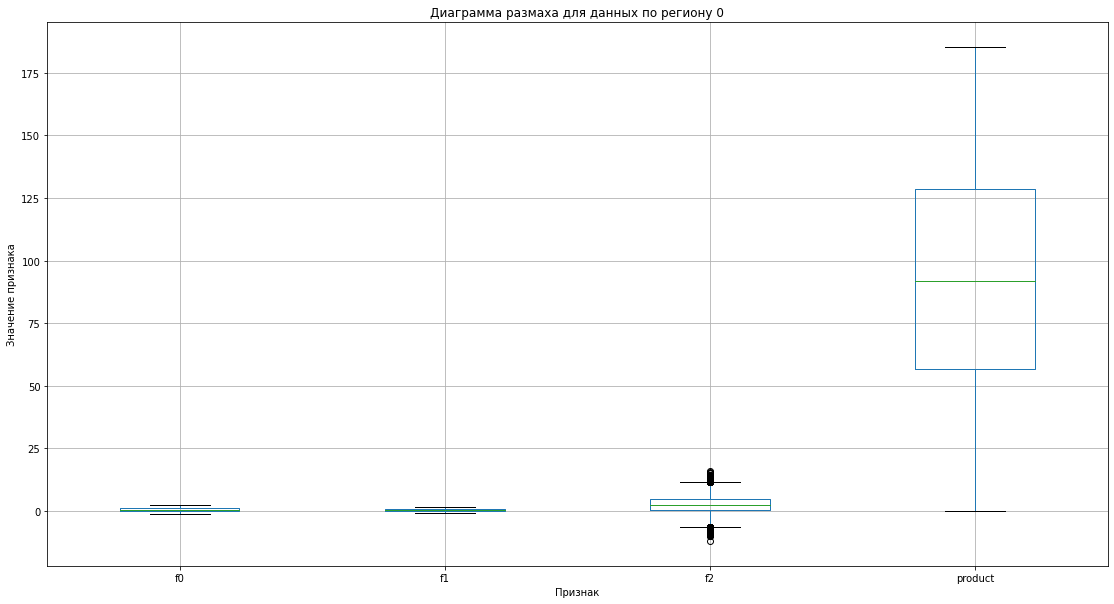

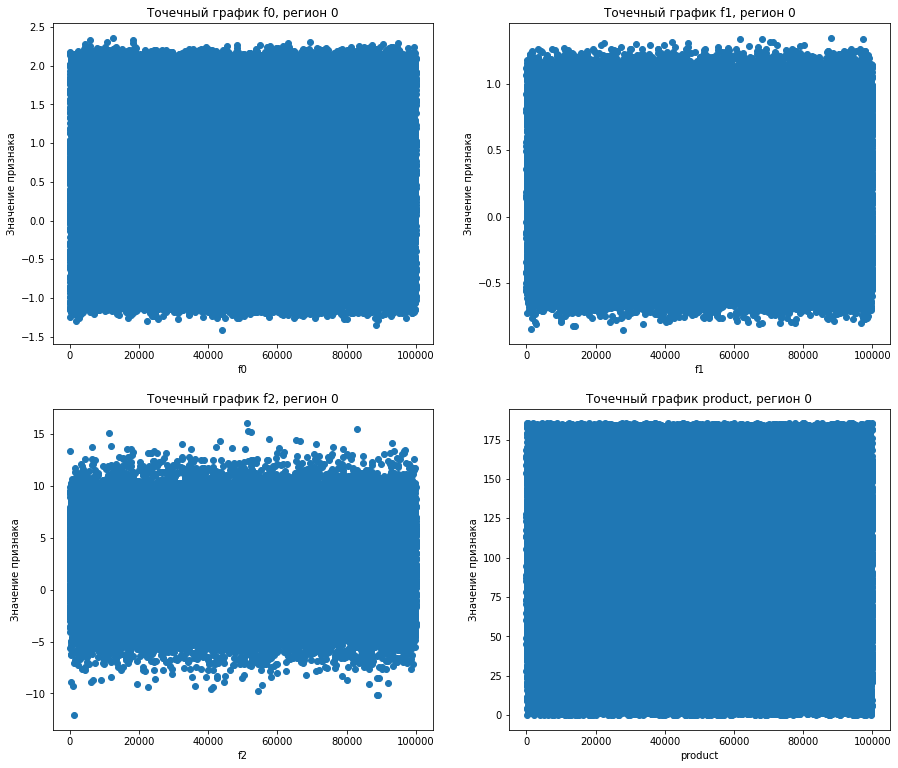

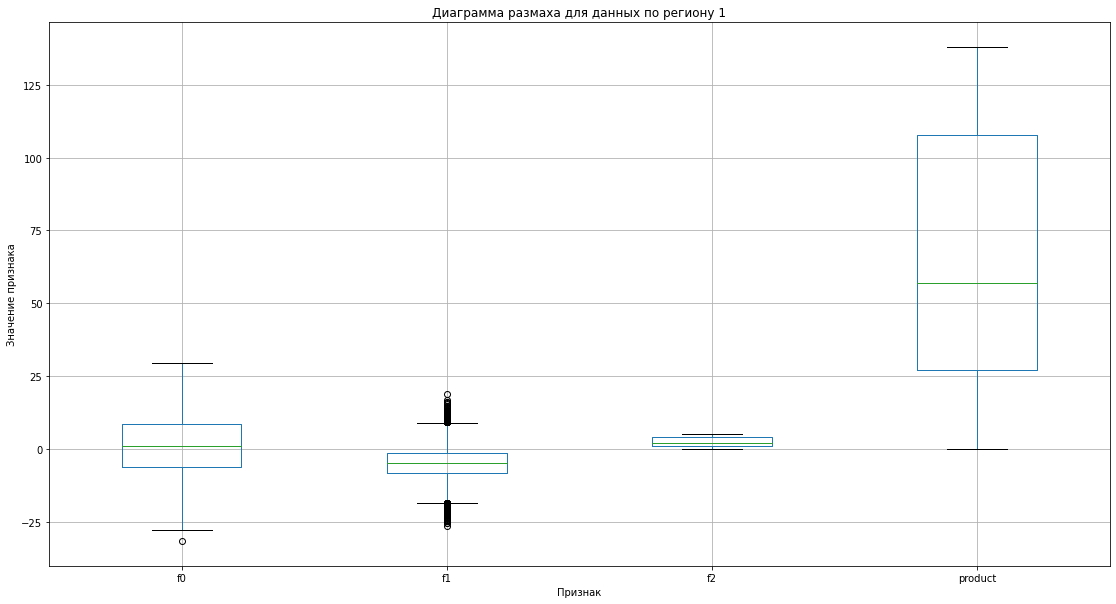

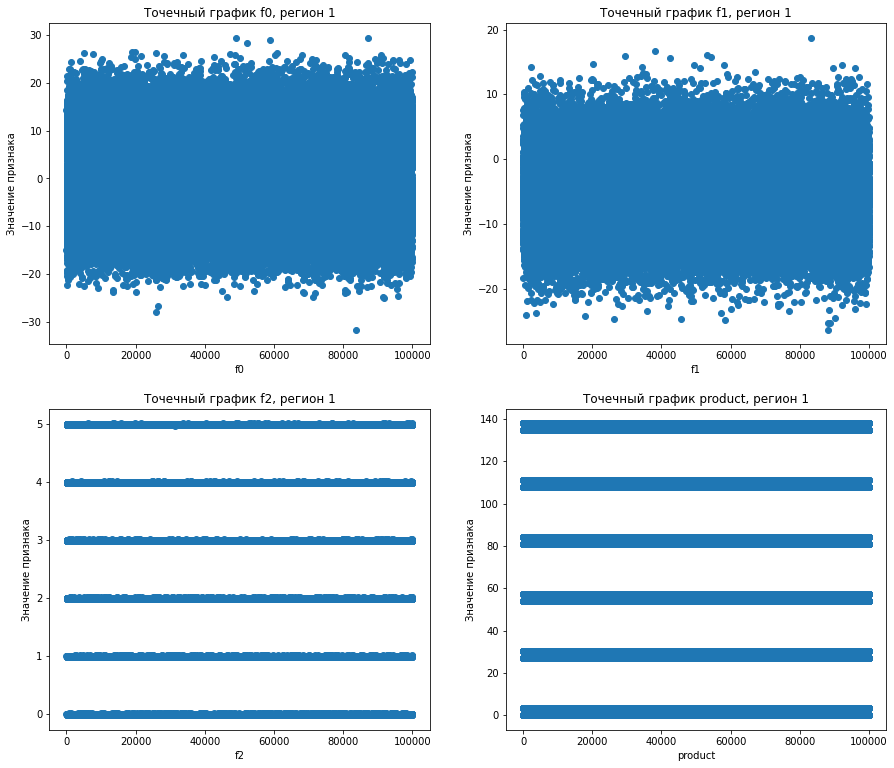

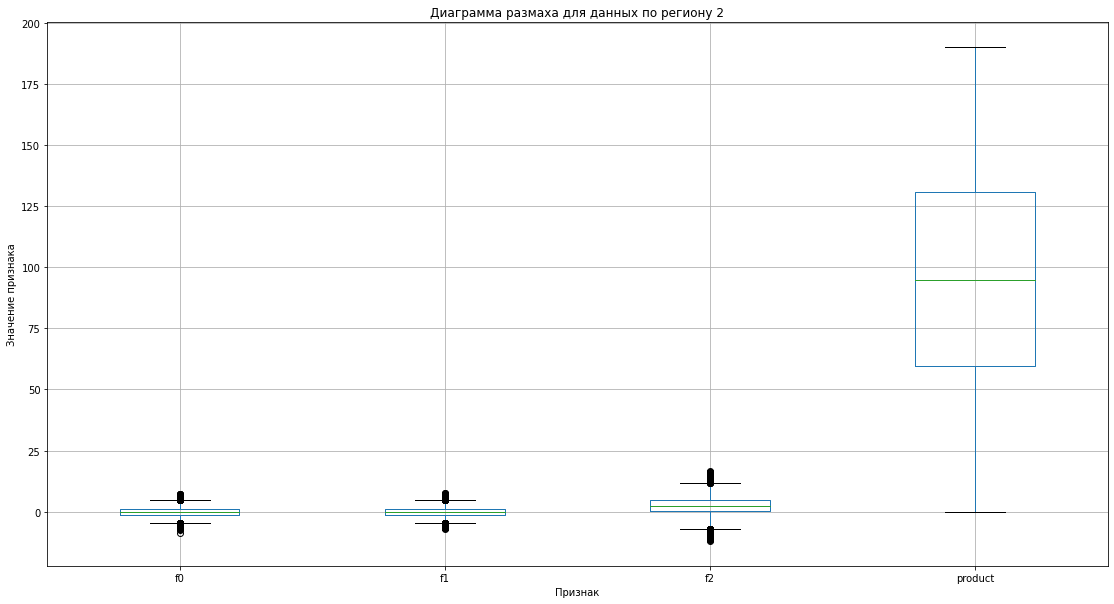

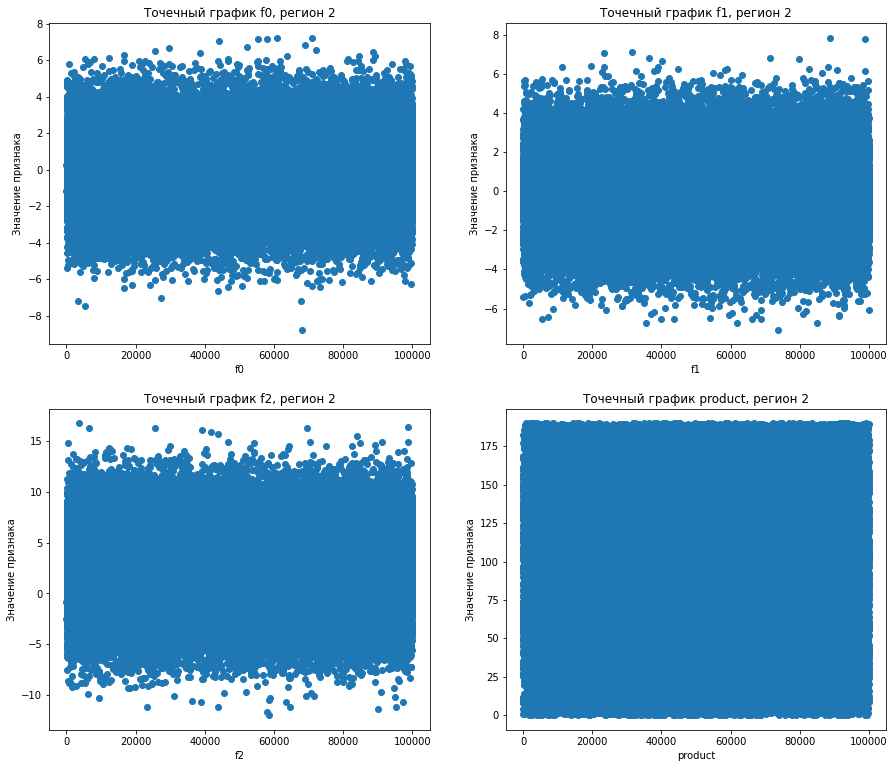

In [313]:
#зададим вспомогательные начальные значения
sbplot_number=[221, 222, 223, 224]

#запустим цикл построения графиков
for reg, region in enumerate([geo_0, geo_1, geo_2]):
        
    #построим диаграмму размаха
    region.boxplot(figsize=(19, 10))

    #добавим элементы оформления к диаграмме размаха
    plt.title('Диаграмма размаха для данных по региону '+str(reg));
    plt.xlabel('Признак');
    plt.ylabel('Значение признака');
    plt.show()
    
    #создадим полотно для точечных графиков
    fig = plt.figure(figsize=(15,13))

    #добавим на полото точечный график для кажтого признака
    for i, prizn in enumerate(list(geo_0.columns)):
        ax = fig.add_subplot(sbplot_number[i])
        region[prizn].plot(style='o', xlabel = prizn, ylabel = 'Значение признака', title = 'Точечный график '+prizn+', регион '+str(reg))
    
    plt.show()  


Анализируя приведенные выше графические материалы, можно сделать вывод о том, что выбросы присутствуют, однако их очень мало и они не приводят к выбросам в значениях целевого признака. Оставим данные без изменения.

# 2. Обучение модели прогноза объема добычи

## 2.1 Подготовка данных к обучению модели

В рамках подготовки данных к обучению модели выполним следующие шаги:
- в соотношении 3:1 разобъем выборки для каждого региона на обучающую и валидационную (соотношение указано в задании на проект);
- выделим features и target для каждого региона.

### 2.1.1 Разбиение выборок на обучающую и валидационную

In [314]:
#зафиксируем показатель псевдослучайной выборки
STATE = 12345

In [315]:
#сформируем обучающую и валидационную выборки для региона 0
train_0, valid_0 = train_test_split(geo_0, test_size=0.25, random_state=STATE) 

In [316]:
#сформируем обучающую и валидационную выборки для регионов 1 и 2
train_1, valid_1, train_2, valid_2 = train_test_split(geo_1, geo_2, test_size=0.25, random_state=STATE) 

In [317]:
#проверим результаты для региона 0
print(train_0.shape)
print(valid_0.shape)

(74992, 4)
(24998, 4)


In [318]:
#проверим результаты для региона 1
print(train_1.shape)
print(valid_1.shape)

(74997, 4)
(24999, 4)


In [319]:
#проверим результаты для региона 2
print(train_2.shape)
print(valid_2.shape)

(74997, 4)
(24999, 4)


Обучающая и валидационная выборки сформированы в правильном соотношении размерностей.

### 2.1.2 Выделение признаков и целевого признака для каждого региона

In [320]:
def features_and_target(data_train, data_valid, target_name):
    
    #разделим выборки на features и target
    features_train = data_train.drop(columns=target_name).reset_index(drop=True)
    features_valid = data_valid.drop(columns=target_name).reset_index(drop=True)
    target_train = data_train[target_name].reset_index(drop=True)
    target_valid = data_valid[target_name].reset_index(drop=True)
    
    #проверим результат
    display('Размер обучающих выборок')
    display(features_train.shape)
    display(target_train.shape)

    display('Размер валидационных выборок')
    display(features_valid.shape)
    display(target_valid.shape)
    
    return features_train, target_train, features_valid, target_valid

In [321]:
#выделим features и target для региона 0
features_train_0, target_train_0, features_valid_0, target_valid_0 = features_and_target(train_0, valid_0, 'product')

'Размер обучающих выборок'

(74992, 3)

(74992,)

'Размер валидационных выборок'

(24998, 3)

(24998,)

In [322]:
#выделим features и target для региона 1
features_train_1, target_train_1, features_valid_1, target_valid_1 = features_and_target(train_1, valid_1, 'product')

'Размер обучающих выборок'

(74997, 3)

(74997,)

'Размер валидационных выборок'

(24999, 3)

(24999,)

In [323]:
#выделим features и target для региона 2
features_train_2, target_train_2, features_valid_2, target_valid_2 = features_and_target(train_2, valid_2, 'product')

'Размер обучающих выборок'

(74997, 3)

(74997,)

'Размер валидационных выборок'

(24999, 3)

(24999,)

## 2.2 Cоздание модели и прогноз

На текущем этапе для каждого региона необходимо обучить модель, предсказывающую объем добытого сырья, и сделать предсказание на валидационной выборке.

Напишем функцию, принимающую на вход обучающие выборки features и target и валидационные выборки features и target.
В результате работы функция возвращает модель, предсказание и значение RMSE.

In [324]:
def training(features_train, target_train, features_valid, target_valid):
    
    #1. Выполним стандартизацию признаков
    #создадим и настроим StandardScaler
    scaler = StandardScaler()
    scaler.fit(features_train)

    #стандартизируем признаки в features_train и features_valid
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    #2. Создадим и обучим модель
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid)
    
    #3. Рассчитаем значения rmse
    rmse = (mean_squared_error(target_valid, predictions_valid))**0.5

    return model, predictions_valid, rmse

Создадим модель для каждого региона, выполним прогноз объема добычи и рассчитаем величину RMSE.

In [325]:
%%time

#нулевой регион
model_0, predictions_0, rmse_0 = training(features_train_0, target_train_0, features_valid_0, target_valid_0)
print('RMSE предсказаний для региона 0:', rmse_0)

RMSE предсказаний для региона 0: 37.853527328872964
CPU times: total: 15.6 ms
Wall time: 18 ms


In [326]:
%%time

#первый регион
model_1, predictions_1, rmse_1 = training(features_train_1, target_train_1, features_valid_1, target_valid_1)
print('RMSE предсказаний для региона 1:', rmse_1)

RMSE предсказаний для региона 1: 0.8920592647717037
CPU times: total: 31.2 ms
Wall time: 18 ms


In [327]:
%%time

#второй регион
model_2, predictions_2, rmse_2 = training(features_train_2, target_train_2, features_valid_2, target_valid_2)
print('RMSE предсказаний для региона 2:', rmse_2)

RMSE предсказаний для региона 2: 40.07585073246016
CPU times: total: 15.6 ms
Wall time: 17.9 ms


Величина RMSE для нулевого и второго регионов составляет 37.9 и 40.1 тысяч баррелей соответственно. Величина RMSE для первого региона намного лучше и составляет 0.9 тыс. баррелей, что, вероятно, вызвано особенностями данных. Посмотрим на матрицу корреляции для каждого региона.

In [354]:
for i, region in enumerate([geo_0, geo_1, geo_2]):
    print('*** Матрица корреляции для региона', i, '***')
    display(region.corr())

*** Матрица корреляции для региона 0 ***


,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


*** Матрица корреляции для региона 1 ***


,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


*** Матрица корреляции для региона 2 ***


,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


Анализируя матрицы корреляций, можно заметить, что для региона 1 наблюдается чрезвычайно высокий коэффициент корреляции между f2 и product. Вероятно, этим и обусловлена точность предсказания.

Объединим результаты предсказаний для каждого региона в таблицу и рассчитаем общий и средний объемы предсказанных и реальных запасов  нефти в каждом регионе.

In [328]:
predict_result  = {'region': [0, 1, 2], 
                   'real_total_volume': [target_valid_0.sum(), target_valid_1.sum(), target_valid_2.sum()],
                   'real_mean_volume': [target_valid_0.mean(), target_valid_1.mean(), target_valid_2.mean()],
                   'predicted_total_volume': [predictions_0.sum(), predictions_1.sum(), predictions_2.sum()],
                   'predicted_mean_volume': [predictions_0.mean(), predictions_1.mean(), predictions_2.mean()],
                   'RMSE': [rmse_0, rmse_1, rmse_2]}
                    
predict_result = pd.DataFrame(predict_result)
predict_result

,region,real_total_volume,real_mean_volume,predicted_total_volume,predicted_mean_volume,RMSE
0,0,2.303771e+06,92.158205,2.319543e+06,92.789156,37.853527
1,1,1.729582e+06,69.186044,1.729389e+06,69.178320,0.892059
2,2,2.369533e+06,94.785109,2.371548e+06,94.865725,40.075851


Рассчитаем разницу между реальными и предсказанными объемами.

In [329]:
predict_result['delta_total_volume'] = predict_result['predicted_total_volume'] - predict_result['real_total_volume']
predict_result['delta_mean_volume'] = predict_result['predicted_mean_volume'] - predict_result['real_mean_volume']
predict_result

,region,real_total_volume,real_mean_volume,predicted_total_volume,predicted_mean_volume,RMSE,delta_total_volume,delta_mean_volume
0,0,2.303771e+06,92.158205,2.319543e+06,92.789156,37.853527,15772.524932,0.630951
1,1,1.729582e+06,69.186044,1.729389e+06,69.178320,0.892059,-193.103257,-0.007724
2,2,2.369533e+06,94.785109,2.371548e+06,94.865725,40.075851,2015.305683,0.080615


В результате сравнения средних реальных запасов нефти по регионам и средних предсказанных, можно сказать следующие **выводы**:
- разница в среднем ожидаемом и среднем реальном объемах для регионов 1 и 2 не превышает по модулю 0.1 тыс. баррелей, что эквивалентно 45 тыс. рублей средней выручки. Для региона 1 модель предсказала объем сырья меньше реального, для региона 2 - больше реального;
- ошибка в определении общего объема сырья по предсказаниям увеличивается пропорционально количеству скважин: так при количестве скважин ~25 тысяч, ожидаемый объем сырья для региона 1 меньше реального на 193 тыс баррелей (87 млн рублей, что в принципе неплохо - ожидаем меньше, получим больше), для региона 2 - больше реального на 2015 тыс баррелей (907 млн рублей). Можно предположить, что полученные ошибки в оценке среднего и общего объема сырья (следовательно, и выручки) приемлемы в рамках действия крупной корпорации;
- для региона 0 ошибка в среднем объеме составила 0.6 тыс баррелей, что немного для одной скважины, однако для 25 тыс скважин ошибка в объеме суммарно будет составлять 15,8 мн баррелей (7.1 млрд выручки);
- наилучшим RMSE (0.89) обладает модель для региона 1, значение метрики RMSE для моделей регионов 0 и 2 близки - 38 и 40 тыс баррелей соответственно;
- по объемам запасов наименее перспективный - регион 1, наиболее - регионы 0 и 2 (с небольшим отрывом друг от друга).

# 3. Подготовка к расчету прибыли

Весь бюджет на разработку скважин в регионе составляет BUDGET = 10 млрд руб. Количество планируемых новых скважин в регионе составляет N = 200. Доход REVENUE с 1 единицы сырья составляет 450 000 рублей. 

Для обеспечения безубыточности разработки, доход от каждой скважины в среднем должен быть не менее суммы, затрачиваемой на ее разработку. В таком случае минимальный средний объем нефти по двумстам разрабатываемым скважинам можно рассчитать по формуле: 

**Vm = BUDGET/(N x REVENUE)**

Минимальный объем добываемой нефти с региона в зоне разработки новых скважин составляет: **Vt = BUDGET/REVENUE**

In [330]:
BUDGET = 10**10
N = 200
REVENUE = 45*10**4

In [331]:
#рассчитаем средний объем добычи с одной скважины
vm = BUDGET/(N*REVENUE)

#рассчитаем минимальный объем добычи с участка
vt = BUDGET/REVENUE

#покажем результаты
print('Минимальный средний объем добычи с одной скважины:', round(vm, 2), 'тыс. баррелей')
print('Минимальный объем добычи с участка:', round(vt, 2), 'тыс. баррелей')

Минимальный средний объем добычи с одной скважины: 111.11 тыс. баррелей
Минимальный объем добычи с участка: 22222.22 тыс. баррелей


In [ ]:
#рассчитаем средние значения объемов сырья по регионам
display(geo_0['product'].mean())
display(geo_1['product'].mean())
display(geo_2['product'].mean())

Средние показатели объемов добычи для каждого региона меньше минимального безубыточного объема - 111.11 тыс баррелей.

# 4. Создание функции для расчета прибыли

Напишем функцию, принимающую на вход следующие аргументы:
- выборку с предполагаемым объемом добычи с каждой скважины;
- выборку с реальным объемом добычи с каждой скважины;
- количество планируемых скважин;
- бюджет на разработку новых скважин;
- сумму выручки с единицы продукта.

Функция выбирает заданное количество наилучших скважин (по предсказанию), затем для этих скважин осуществляет расчет фактических объемов добычи (по target из исходных данных), на основании чего производит расчет прибыли.


Функция должна возвращать:
- общий объем добычи;
- средний объем добычи;
- общую выручку;
- общую прибыль.

In [342]:
def profit_calculate(data_predict, data_real, amount, budget, revenue):
    
    #выберем заданное количество наиболее продуктивных скважин
    best_oilwell_pred = data_predict.sort_values(ascending=False)[:amount]
    best_oilwell_real = data_real[best_oilwell_pred.index]
    
    #рассчитаем общее предполагаемое количество сырья
    total_product_real = round(best_oilwell_real.sum(), 3)
    
    #рассчитаем среднее количество предполагаемого сырья
    mean_product_real = round(best_oilwell_real.mean(), 3)
    
    #рассчитаем общую выручку от предполагаемого объема добычи
    total_revenue = total_product_real*revenue
    
    #рассчитаем общую прибыль от предполагаемого объема добычи
    total_profit = total_revenue - budget
    
    return total_product_real, mean_product_real, total_revenue, total_profit

Рассчитаем прибыль для 200 самых перспективных скважин.

In [343]:
#создадим словарь для сохранения результатов
pivot_pred_revenue = {'region':[0, 1, 2],
                     'total_product':[],
                     'mean_product':[],
                     'total_revenue':[],
                     'total_profit':[]}

#создадим список, используем его в цикле далее
real_product = [target_valid_0, target_valid_1, target_valid_2]
predicted_product = [predictions_0, predictions_1, predictions_2]

#рассчитаем ожидаемую прибыль для регионов
for i in range(0, 3):
    
    #обнулим значения рассчитываемых показателей
    tprod=0
    mprod=0
    trev=0
    tprof=0

    #рассчитаем требуемые значения
    tprod, mprod, trev, tprof = profit_calculate(predicted_product[i], real_product[i], N, BUDGET, REVENUE)
    
    #сохраним результаты
    pivot_pred_revenue['total_product'].append(tprod)
    pivot_pred_revenue['mean_product'].append(mprod)
    pivot_pred_revenue['total_revenue'].append(format(trev, '.0f'))
    pivot_pred_revenue['total_profit'].append(format(tprof, '.0f'))

#преобразуем словарь с результатами в датафрейм
pivot_pred_revenue = pd.DataFrame(pivot_pred_revenue)
pivot_pred_revenue

,region,total_product,mean_product,total_revenue,total_profit
0,0,29700.416,148.502,13365187200,3365187200
1,1,27589.082,137.945,12415086900,2415086900
2,2,27780.631,138.903,12501283950,2501283950


Двести лучших скважин в регионе 0 позволяют получить прибыль +3.4 млрд рублей, в регионе 1 - +2.4 млрд рублей, в регионе 2 - +2.5 млрд рублей. 

Несмотря на то, что общие запасы в регионе 1 в 1.4 раза меньше, чем в регионе 2, разница в прибыли составляет всего ~3%.
Средний запас сырья в регионах 0 и 2 практически одинаков, однако предполагаемая прибыль в регионе 0 на 36% выше.

# 5. Расчет рисков и прибыли для каждого региона

С помощью техники Bootstrap рассчитаем риски и прибыль для каждого региона.

Напишем функцию, выполняющую следующие операции:
- формирование тысячи выборок объемом 500 скважин;
- расчет прибыли для двухсот лучших скважин (средняя общая прибыль) для каждой выборки;
- расчет среднего значения прибыли для двухсот лучших скважин;
- расчет границ 95% доверительного интервала среднего значения прибыли;
- вероятность убытков.

In [360]:
def bootstrap_profit(pred_data, real_data):
    
    #сформируем псевдослучайную последовательность 
    state = np.random.RandomState(STATE)
    #создадим список для хранения прибыли
    profits = []
    
    #ассчитаем значения прибыли для 1000 выборок
    for i in range(1000):
        subsample = pred_data.sample(500, replace=True, random_state=state)
        btprod, bmprod, btrev, btprof = profit_calculate(subsample, real_data, N, BUDGET, REVENUE)
        profits.append(btprof)
        
    profits = pd.Series(profits)
    
    #рассчитаем среднее значение прибыли, нижний и верхний границы 95%-го интервала доверия и вероятность убыточной прибыли
    mean_profit = profits.mean()
    lower = round(profits.quantile(0.025), 2)
    upper = round(profits.quantile(0.975), 2)
    loss_percent = (profits<0).mean()*100   
        
    return mean_profit, lower, upper, loss_percent

In [362]:
#создадим словарь для записи результатов
pivot_butstrap_profit = {'reg':[0, 1, 2],
                        'mean_profit':[],
                        'lower_bord':[],
                        'upper_bord':[],
                        'loss_percent':[]}
for i in range(0, 3):
    
    #обнулим рассчитываемые показатели
    mean_profit = 0
    lower = 0
    upper = 0
    loss_percent = 0
    
    #рассчитаем среднее значение прибыли, нижний и верхний границы 95%-го интервала доверия и вероятность убыточной прибыли
    mean_profit, lower, upper, loss_percent = bootstrap_profit(predicted_product[i], real_product[i])
    
    #сохраним результаты
    pivot_butstrap_profit['mean_profit'].append(format(mean_profit, '.3f'))
    pivot_butstrap_profit['lower_bord'].append(format(lower, '.3f'))
    pivot_butstrap_profit['upper_bord'].append(format(upper, '.3f'))
    pivot_butstrap_profit['loss_percent'].append(loss_percent)
    
#сформируем результаты и покажем их    
pivot_butstrap_profit = pd.DataFrame(pivot_butstrap_profit)
pivot_butstrap_profit

,reg,mean_profit,lower_bord,upper_bord,loss_percent
0,0,380613472.100,-142942667.500,890976837.500,7.7
1,1,478484941.400,89525138.750,866604691.250,1.2
2,2,330546262.850,-190365771.250,840467273.750,11.3


**Выводы**:
- наибольшая средняя общая прибыль (478.5 млн рублей) ожидается для региона 1. Для этого же региона характерна наименьшая вероятность убытков (1.2%);
- промежуточное значение средней общей прибыли (380.6 млн руб) ожидается в регионе 0, вероятность убытков - 7.7%;
- наименьшая ожидаемая средняя общая прибыль характерна для региона 2 и составляет 330.5 млн. руб. Вероятность убытков наибольшая и составляет 11.3%.

# 6. Общий вывод

- В рамках выполнения проекта для каждого региона на основе алгоритма линейной регрессии была обучена модель предсказания объема добычии. Качество модели оценивалось по значению метрики RMSE. Наилучшее значение RMSE наблюдается для региона 1 (0.89 баррелей), наихудшее - для региона 2 (40.08 тыс. баррелей). RMSE для региона 0 составяляет 37.85, что очень близко к наихудшему значению. Подобные результаты могут быть обусловлены как качеством самих моделей, так и недостаточной чистотой данных - например, для региона 1 с наилучшим RMSE корреляция между характеристикой f2 и объемом сырья составляет 0.999.

- В целом для всех регионов средний предсказанный объем отличается от реального менее, чем на 1 тыс баррелей: ошибка для региона 1 составляет -0.008 тыс баррелей (предсказано чуть меньше реального значения), для региона 0 - +0,63 тыс баррелей, для региона 2 - +0,081 тыс. баррелей, что в эквиваленте выручки составляет менее 450 тыс рублей. Можно предположить, что полученные ошибки в значении предполагаемого среднего приемлемы в рамках работы крупной нефтяной компании, однако следует учитывать, что ошибка в определении общего объема, а следовательно, и выручки, будет увеличиваться пропорционально количеству скважин;

- Безубыточный средний объем сырья для каждой скважины составляет 111.11 тыс баррелей, что больше средних запасов по каждому региону (из расчета по всем скважинам в регионе). Наименьшим запасом сырья обладает регион 1 (69.2 тыс баррелей), примерно одинаковые запасы у регионов 1 и 3 - 92.2 и 94.8 тыс. баррелей.

- Средний запас сырья для двухсот лучших скважин составляет 148.5, 137.9 и 138.9 тыс баррелей для регионов 0, 1, 2 соответственно. 


- На основании расчетов распределения прибыли и вероятности убытков, можно **рекомендовать к разработке регион 1**:
    - средняя ожидаемая общая прибыль для региона 1 максимальна и составляет 478.5 млн рублей (2.4 млн рублей/скважину);
    - вероятность убытков составляет 1.2% (наименьшая вероятность убытков среди всех регионов и единственная не превышающая порог в 2.5%);
    - модель прогноза объема добычи для региона 1 имеет самое лучшее значение метрики RMSE, на основании чего можно судить о достоверности полученных результатов для этого региона.
